In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import itertools

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers import ...

In [3]:
import pandas as pd
df = pd.read_csv('hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104089,8,2021,710 YISHUN AVENUE 5,Yishun,0.826153,14.410089,0.016807,0.000382,"4 ROOM, New Generation",61.750000,93.0,07 TO 09,390000.0
104090,8,2021,117 YISHUN RING ROAD,Yishun,1.045337,15.215236,0.016807,0.000382,"4 ROOM, Model A",60.916667,104.0,07 TO 09,380000.0
104091,8,2021,453 YISHUN STREET 41,Khatib,1.424543,13.350952,0.016807,0.000968,"4 ROOM, Model A",91.083333,93.0,04 TO 06,433000.0
104092,8,2021,505D YISHUN STREET 51,Khatib,1.259536,13.232993,0.016807,0.000968,"4 ROOM, Model A",93.666667,93.0,01 TO 03,460000.0


In [4]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = tf.keras.layers.Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = tf.keras.layers.StringLookup if is_string else tf.keras.layers.IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="one_hot") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


# Q1

Columns to be used in network

In [5]:
numerical_features = [
    'dist_to_nearest_stn',
    'dist_to_dhoby',
    'degree_centrality',
    'eigenvector_centrality',
    'remaining_lease_years',
    'floor_area_sqm'
]
categorical_string = [
    'flat_model_type',
    'storey_range'
]
categorical_non_string = [
    'month'
]

The aim is to predict future prices with pasts price data. If random train/valid is used, the future target prices (2021) will also be present in the train set.

This is inherently wrong as:
- instead of learning trends in past price data and extending these trends to future data
- the model would be learning future data trends from the train set (in a sense cheating)

In [6]:
#Split data
train_dataframe = df[df['year'] <= 2020]
val_dataframe = df[df['year'] >= 2021]
train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

2021-09-30 07:17:31.218587: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Helper functions:

- `prep_inputs`
    - encode numerical and categorical features respectively
    - can specify embedding layer for categorical features

In [7]:
def prep_inputs(embedding=False):
    all_inputs = []
    all_features = []
    for col in df.columns:
        append = False
        if col in numerical_features:
            feature = tf.keras.layers.Input((1,), name=col)
            encoded_feature = encode_numerical_feature(feature, col, train_ds)
            append = True
            
        elif col in categorical_string + categorical_non_string:
            is_string = col in categorical_string
            feature = tf.keras.layers.Input((1,), name=col, dtype='string' if is_string else 'int64')
            encoded_feature = encode_categorical_feature(feature, col, train_ds, is_string)
            if embedding:
                input_dim = len(df[col].unique())
                encoded_feature = tf.keras.layers.Embedding(input_dim, input_dim // 2)(encoded_feature)
                encoded_feature = tf.keras.layers.Flatten()(encoded_feature)
            append = True
            
        if append:
            all_inputs.append(feature)
            all_features.append(encoded_feature)

    return all_inputs, all_features
all_inputs, all_features = prep_inputs()

- `r_squared`
    - compute r sqaured between inferred and target `resale_price`

- `make_network`
    - clears tf session
    - can specify `drop`
        - will collect input layers and features not in `drop`
    - concatenate features
    - build question specified model
    - returns visualization of model and model
    
- `run_network`
    - wrapper to run `model.fit` for training
    - `mse` is used, when plotting results, this will be scaled to `rmse`

In [8]:
def r_squared(y, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

def make_network(
    all_inputs=all_inputs,
    all_features=all_features,
    mask=None,
    drop=[]
):
    tf.keras.backend.clear_session() # clear tf session
    
    if mask is None: # keep all inputs and features
        mask = [1] * len(all_inputs)

    inputs = list(itertools.compress(all_inputs, mask))
    features = list(itertools.compress(all_features, mask))
        
    print(f'{mask}\ncurrent {len(inputs)} inputs:\n\t' +
          '\n\t'.join(inpt.name for inpt in inputs) + '\n')
    
    features = tf.keras.layers.concatenate(features)
    x = layers.Dense(10, activation='relu')(features)
    output = layers.Dense(1)(x)
    model = keras.Model(inputs, output)
    model.compile(
        tf.keras.optimizers.Adam(.05),
        'mse',
        metrics=r_squared
    )
    return tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR'), model

def run_network(
    model,
    train_ds=train_ds,
    epochs=100,
    batch_size=128,
    validation_data=val_ds,
    callbacks=[],
    verbose=0
):
    return model.fit(
        train_ds,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=val_ds,
        callbacks=callbacks,
        verbose=verbose
    )

[1, 1, 1, 1, 1, 1, 1, 1, 1]
current 9 inputs:
	month
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



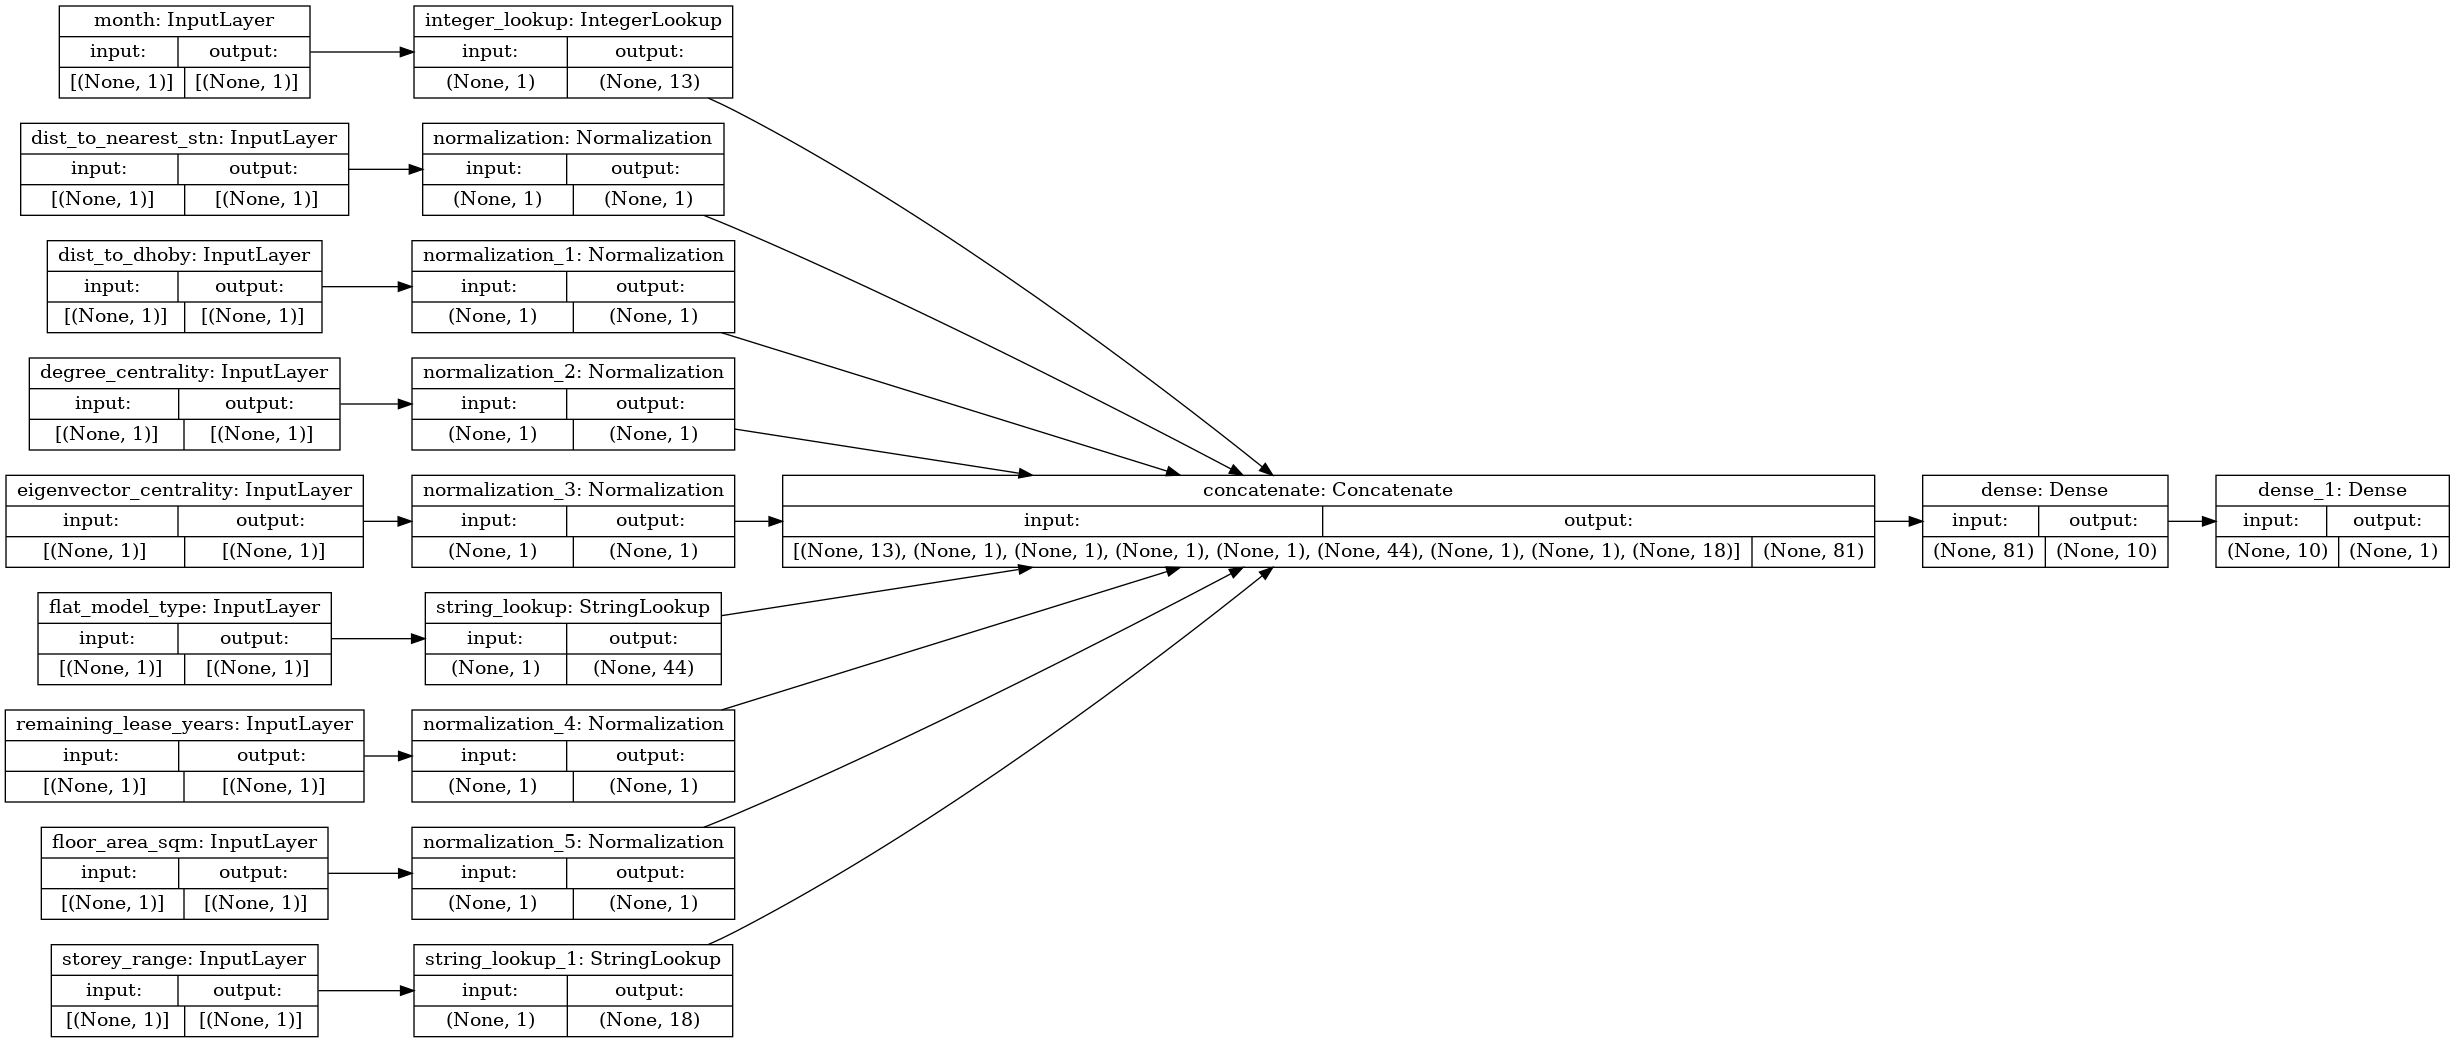

In [9]:
# only use this callback to restore weights
# not to stop early
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    patience=100, 
    restore_best_weights=True,
)]

visualization, model = make_network()
visualization

In [10]:
%%time
q1 = run_network(
    model,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


CPU times: user 7min 37s, sys: 49.5 s, total: 8min 26s
Wall time: 4min 49s


helper function `plot`:
- scale `mse` to `rmse`
- ignores the first `truncate` epochs

In [11]:
import matplotlib.pyplot as plt
def plot(history, truncate=2, suptitle_label=''):
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    f.subplots_adjust(top=.75 if suptitle_label == '' else .7)
    
    def scale_history(values, sqrt=False, truncate=truncate):
        if sqrt:
            values = list(np.sqrt(values))
        return [values[truncate]] * truncate + values[truncate:]

    r_squared = scale_history(history['r_squared'])
    loss = scale_history(history['loss'], True) # calc rmse from mse
    val_r_squared = scale_history(history['val_r_squared'])
    val_loss = scale_history(history['val_loss'], True) # calc rmse from mse
    
    axes[1].plot(r_squared)
    axes[1].plot(val_r_squared)
    axes[1].set_title('Model r_squared')
    axes[1].set(ylabel = 'r_squared', xlabel = 'Epoch')
    axes[1].legend(['Train', 'Valid'], loc='upper left')
    axes[0].plot(loss)
    axes[0].plot(val_loss)
    axes[0].set_title('Model loss')
    axes[0].set(ylabel = 'Loss (RMSE)', xlabel = 'Epoch')
    axes[0].legend(['Train', 'Valid'], loc='upper left')
    axes[0].grid()
    axes[1].grid()
    
    title = (
        suptitle_label +
        'Min Training loss (RMSE): {:.{}f}\n'.format(min(loss), 3) +
        'Max Training r_squared: {:.{}f}\n'.format(max(r_squared), 3) +
        'Min Validation loss (RMSE): {:.{}f}\n'.format(min(val_loss), 3) +
        'Max Validation r_squared: {:.{}f}\n'.format(max(val_r_squared), 3)
    )
    f.suptitle(title)
    axes[0].set_xlim((truncate, 100))
    axes[1].set_xlim((truncate, 100))

- large divergence
    - overfitting

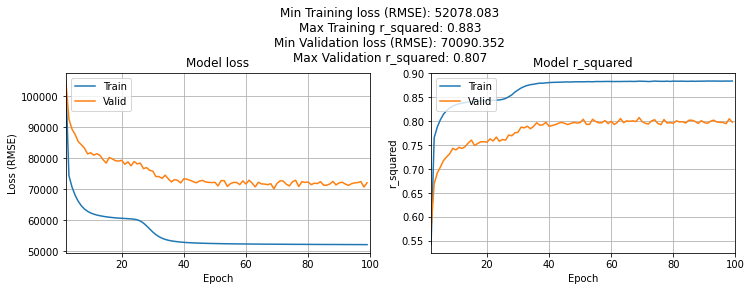

In [12]:
plot(q1.history)

In [13]:
index = np.argmin(q1.history['val_loss']) # lowest validation mse error
print(f'epoch {index} has lowest mse of {round(q1.history["val_r_squared"][index], 3)}')

epoch 69 has lowest mse of 0.807


model is already loaded with best weights due to `EarlyStopping`

In [14]:
for x, targets in val_ds.take(1).as_numpy_iterator():
    break
preds = model.predict(x)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


plot generally follows line `y = x` which is good
- suggests that model has somewhat learnt to predict validation `resale_prices`

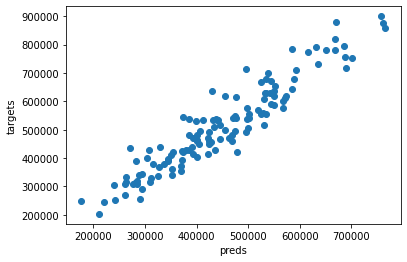

In [15]:
plt.scatter(preds, targets)
plt.xlabel('preds')
plt.ylabel('targets');

# Q2

add `Embedding` layer for categorical features

[1, 1, 1, 1, 1, 1, 1, 1, 1]
current 9 inputs:
	month
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



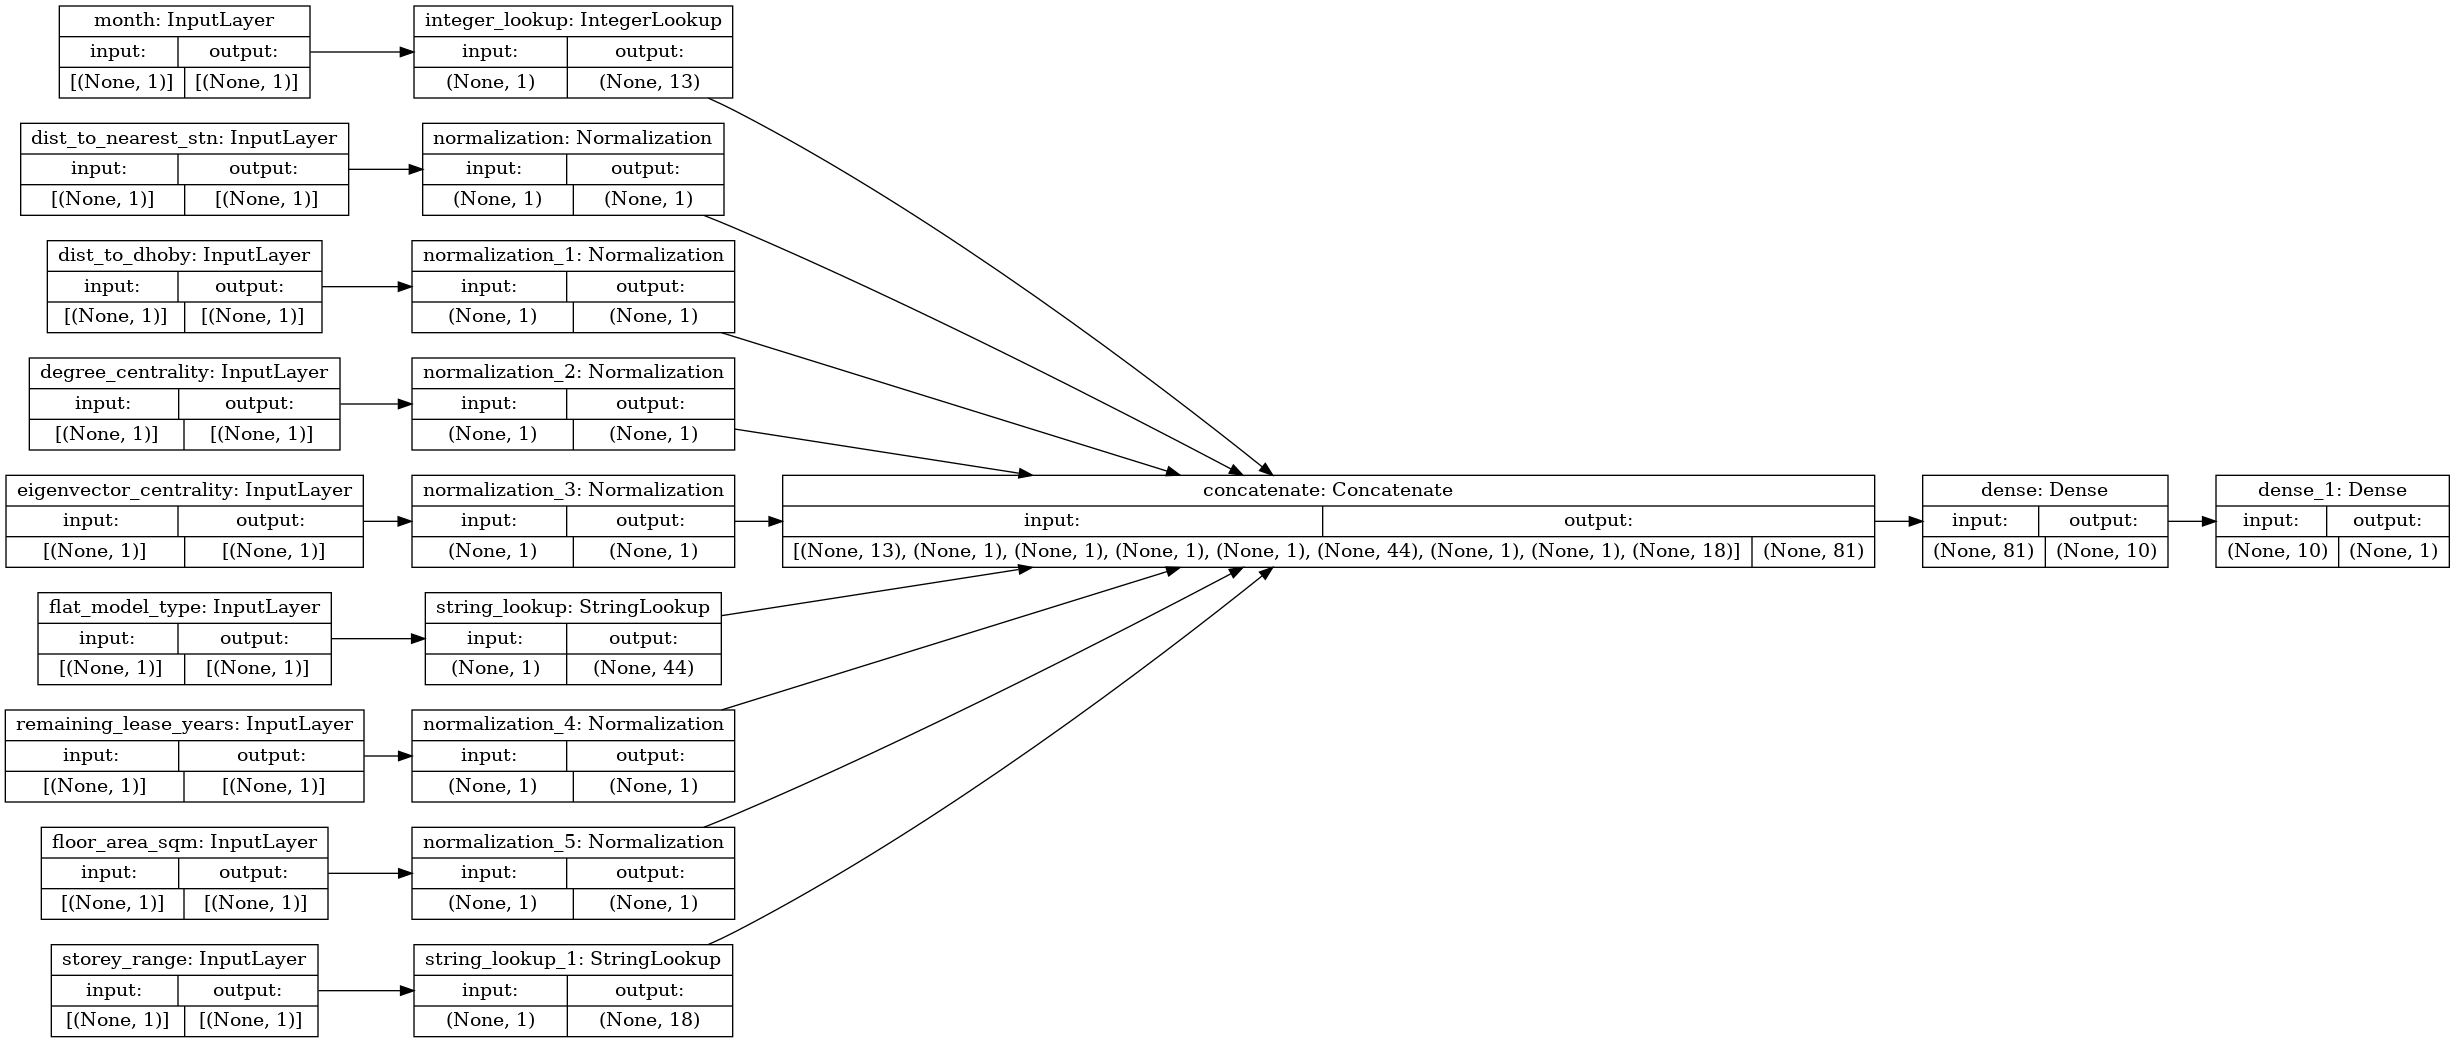

In [16]:
all_inputs, all_features = prep_inputs(embedding=True)
visualization, model = make_network()
visualization

In [17]:
%%time
q2 = run_network(
    model,
    callbacks=callbacks
)

CPU times: user 7min 43s, sys: 49.7 s, total: 8min 33s
Wall time: 4min 51s


Observations:
- adding `Embedding()` improves performance
    - `RMSE` decreases
    - `R_Squared` increases
    - divergence decreases
        - weights learnt in `train` are more generalizable to `valid`
   
Insights:
- `Embedding()` allows for encoding of more information and thus leads to better performance
    - eg, instead of `0 1 0 # storey range 4-6`, `0.3 0.1 0` where `0.3` could represent the scale of height (0-1) and `0.1` could represent other information 

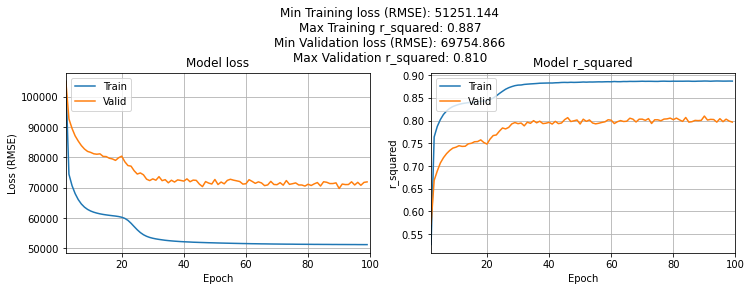

In [18]:
plot(q2.history)

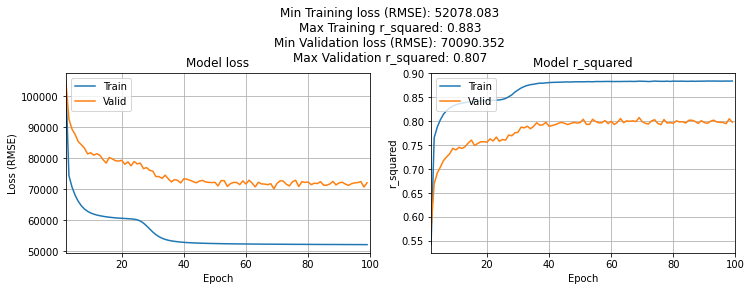

In [19]:
plot(q1.history)

# Q3

In [20]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    patience=10, 
    restore_best_weights=True,
)]

In [21]:
def recursive_feature_elimination(
    callbacks,
    benchmark,
    all_inputs=all_inputs,
    all_features=all_features
):
    mask = [1] * len(all_inputs)
    # init 8 row x 9 col to be converted to dataframe later
    # 9 all_features and 8 iterations of choosing which to drop
    val_loss_memory = {f'w/o_{x.name}': [np.inf] * 9 for x in all_inputs}
    
    for row in range(len(all_inputs) - 1):
        differences = []
        # repeat k times to decide which feature to drop
        for col in range(len(all_inputs)):
            if mask[col] == 0: # already dropped
                continue
            print(f'Popping {all_inputs[col].name}')
            
            mask[col] = 0
            visualization, model = make_network(all_inputs, all_features, mask=mask)
            history = run_network(
                model,
                callbacks=callbacks,
                verbose=0
            )
            mask[col] = 1
            
            val_loss = min(history.history['val_loss'])
            val_loss_memory[f'w/o_{all_inputs[col].name}'][row] = val_loss
            
        latest_losses = [value[row] for value in val_loss_memory.values()]
        # no improvement
        if min(latest_losses) > benchmark:
            break
        # update best performance so far
        benchmark = min(latest_losses)
        # max increase in performance
        # or min drop in performance
        to_drop = np.argmin(latest_losses)
                
        to_drop_name = all_inputs[to_drop].name
        print(f'\nsmallest change: {to_drop_name}\n')
        mask[to_drop] = 0
    
    # apply sqrt to get rmse
    val_loss_memory = pd.DataFrame.from_dict(val_loss_memory).apply(lambda x: round(np.sqrt(x)))
    val_loss_memory.iloc[-1] = val_loss_memory.iloc[-2].values
    val_loss_memory.iloc[-1][f'w/o_{to_drop_name}'] = np.inf
    
    return val_loss_memory

In [22]:
%%time
val_loss_memory = recursive_feature_elimination(
    callbacks=callbacks,
    benchmark=min(q2.history['val_loss'])
)

Popping month
[0, 1, 1, 1, 1, 1, 1, 1, 1]
current 8 inputs:
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping dist_to_nearest_stn
[1, 0, 1, 1, 1, 1, 1, 1, 1]
current 8 inputs:
	month
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'dist_to_nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping dist_to_dhoby
[1, 1, 0, 1, 1, 1, 1, 1, 1]
current 8 inputs:
	month
	dist_to_nearest_stn
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'dist_to_dhoby'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping degree_centrality
[1, 1, 1, 0, 1, 1, 1, 1, 1]
current 8 inputs:
	month
	dist_to_nearest_stn
	dist_to_dhoby
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'degree_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping eigenvector_centrality
[1, 1, 1, 1, 0, 1, 1, 1, 1]
current 8 inputs:
	month
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping flat_model_type
[1, 1, 1, 1, 1, 0, 1, 1, 1]
current 8 inputs:
	month
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'flat_model_type'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping remaining_lease_years
[1, 1, 1, 1, 1, 1, 0, 1, 1]
current 8 inputs:
	month
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'remaining_lease_years'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping floor_area_sqm
[1, 1, 1, 1, 1, 1, 1, 0, 1]
current 8 inputs:
	month
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'floor_area_sqm'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping storey_range
[1, 1, 1, 1, 1, 1, 1, 1, 0]
current 8 inputs:
	month
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'storey_range'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])



smallest change: month

Popping dist_to_nearest_stn
[0, 0, 1, 1, 1, 1, 1, 1, 1]
current 7 inputs:
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'dist_to_nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping dist_to_dhoby
[0, 1, 0, 1, 1, 1, 1, 1, 1]
current 7 inputs:
	dist_to_nearest_stn
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'dist_to_dhoby'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping degree_centrality
[0, 1, 1, 0, 1, 1, 1, 1, 1]
current 7 inputs:
	dist_to_nearest_stn
	dist_to_dhoby
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'degree_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping eigenvector_centrality
[0, 1, 1, 1, 0, 1, 1, 1, 1]
current 7 inputs:
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping flat_model_type
[0, 1, 1, 1, 1, 0, 1, 1, 1]
current 7 inputs:
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'flat_model_type'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping remaining_lease_years
[0, 1, 1, 1, 1, 1, 0, 1, 1]
current 7 inputs:
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'remaining_lease_years'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping floor_area_sqm
[0, 1, 1, 1, 1, 1, 1, 0, 1]
current 7 inputs:
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'floor_area_sqm'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping storey_range
[0, 1, 1, 1, 1, 1, 1, 1, 0]
current 7 inputs:
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'storey_range'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])



smallest change: eigenvector_centrality

Popping dist_to_nearest_stn
[0, 0, 1, 1, 0, 1, 1, 1, 1]
current 6 inputs:
	dist_to_dhoby
	degree_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'dist_to_nearest_stn', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping dist_to_dhoby
[0, 1, 0, 1, 0, 1, 1, 1, 1]
current 6 inputs:
	dist_to_nearest_stn
	degree_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'dist_to_dhoby', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping degree_centrality
[0, 1, 1, 0, 0, 1, 1, 1, 1]
current 6 inputs:
	dist_to_nearest_stn
	dist_to_dhoby
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'degree_centrality', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping flat_model_type
[0, 1, 1, 1, 0, 0, 1, 1, 1]
current 6 inputs:
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'eigenvector_centrality', 'flat_model_type'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping remaining_lease_years
[0, 1, 1, 1, 0, 1, 0, 1, 1]
current 6 inputs:
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	flat_model_type
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'eigenvector_centrality', 'remaining_lease_years'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping floor_area_sqm
[0, 1, 1, 1, 0, 1, 1, 0, 1]
current 6 inputs:
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	flat_model_type
	remaining_lease_years
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'eigenvector_centrality', 'floor_area_sqm'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping storey_range
[0, 1, 1, 1, 0, 1, 1, 1, 0]
current 6 inputs:
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'eigenvector_centrality', 'storey_range'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


CPU times: user 1h 4min 52s, sys: 6min 9s, total: 1h 11min 1s
Wall time: 34min 21s


- column represents RMSE for a run without column name
- row represents each iteration of removing feature that impacts performance the least
- `inf` values denote that this particular feature is already removed during this iteration

e.g:

| w/o_month
| ---
| 69754.9
| inf

denotes RMSE for training without feature `month`, resulting in loss of `69754.9` on the first iteration
- since this happens to be the smallest change in loss from benchmark RMSE in Q2, this is dropped and is thus `inf` on iteration 2

In [23]:
min(np.sqrt(q2.history['val_loss']))

69754.86586611718

In [24]:
val_loss_memory

,w/o_month,w/o_dist_to_nearest_stn,w/o_dist_to_dhoby,w/o_degree_centrality,w/o_eigenvector_centrality,w/o_flat_model_type,w/o_remaining_lease_years,w/o_floor_area_sqm,w/o_storey_range
0,62952.0,71613.0,93056.0,67478.0,65322.0,74530.0,70352.0,74515.0,69945.0
1,inf,72844.0,84102.0,65205.0,62205.0,69660.0,72860.0,63743.0,70108.0
2,inf,69733.0,90410.0,64040.0,inf,73751.0,72056.0,65076.0,67367.0
3,inf,inf,inf,inf,inf,inf,inf,inf,inf
4,inf,inf,inf,inf,inf,inf,inf,inf,inf
5,inf,inf,inf,inf,inf,inf,inf,inf,inf
6,inf,inf,inf,inf,inf,inf,inf,inf,inf
7,inf,inf,inf,inf,inf,inf,inf,inf,inf
8,inf,inf,inf,inf,inf,inf,inf,inf,inf


threshold Q2 `val_loss` to find which combination of features yields the lowest `val_loss` (best performer)

iteration 1
- training without `month` as a feature results in best performance
    - lowest RMSE

iteration 2
- training without `eigenvector_centrality` as a feature results in best performance
    - lowest RMSE
    
iteration 3
- none of the experiments perform better than iteration 2 so stop experiments

In [25]:
val_loss_memory.apply(lambda x: x - min(np.sqrt(q2.history['val_loss'])))

,w/o_month,w/o_dist_to_nearest_stn,w/o_dist_to_dhoby,w/o_degree_centrality,w/o_eigenvector_centrality,w/o_flat_model_type,w/o_remaining_lease_years,w/o_floor_area_sqm,w/o_storey_range
0,-6802.865866,1858.134134,2.330113e+04,-2276.865866,-4432.865866,4775.134134,597.134134,4760.134134,190.134134
1,inf,3089.134134,1.434713e+04,-4549.865866,-7549.865866,-94.865866,3105.134134,-6011.865866,353.134134
2,inf,-21.865866,2.065513e+04,-5714.865866,inf,3996.134134,2301.134134,-4678.865866,-2387.865866
3,inf,inf,inf,inf,inf,inf,inf,inf,inf
4,inf,inf,inf,inf,inf,inf,inf,inf,inf
5,inf,inf,inf,inf,inf,inf,inf,inf,inf
6,inf,inf,inf,inf,inf,inf,inf,inf,inf
7,inf,inf,inf,inf,inf,inf,inf,inf,inf
8,inf,inf,inf,inf,inf,inf,inf,inf,inf


train without `month` and `eigenvector_centrality` but for full 100 epochs for fairer comparison with Q2 results

[0, 1, 1, 1, 0, 1, 1, 1, 1]
current 7 inputs:
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



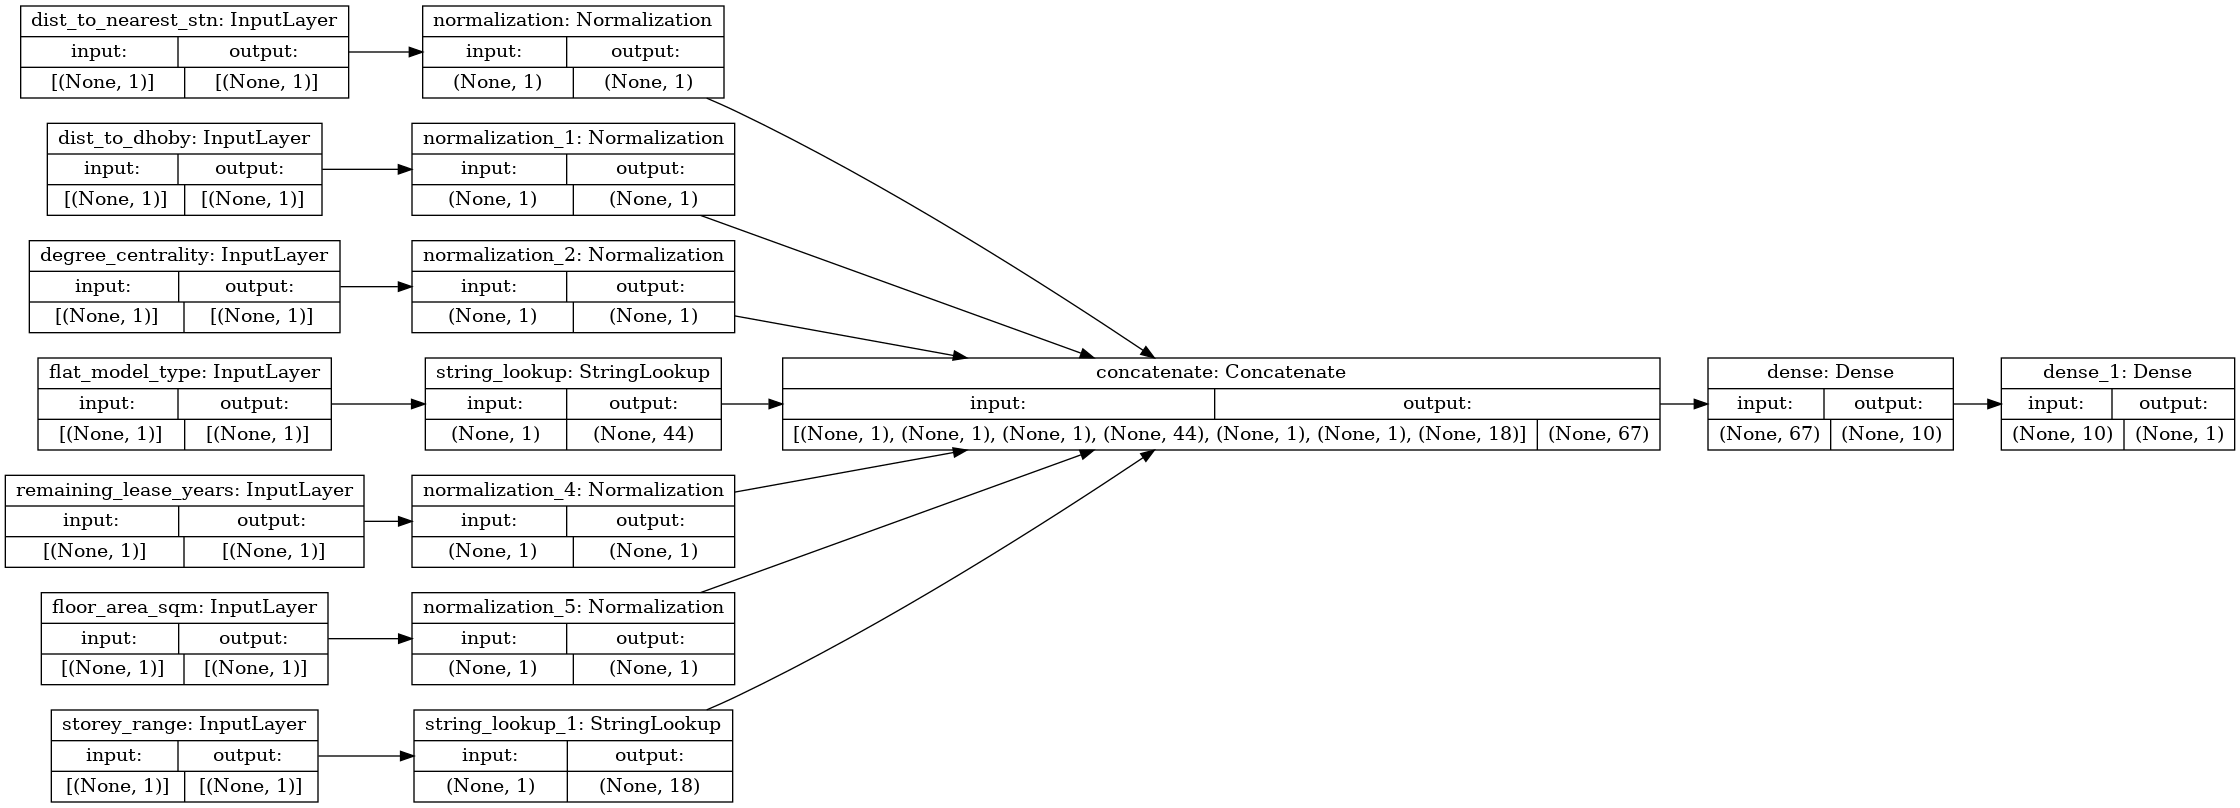

In [26]:
# only use this callback to restore weights
# not to stop early
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    patience=100, 
    restore_best_weights=True,
)]

# drop month, eigenvector_centrality
mask = [1] * 9
mask[0] = 0; mask[4] = 0
visualization, model = make_network(mask=mask)
visualization

In [27]:
%%time
q3 = run_network(
    model,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


CPU times: user 6min, sys: 32.4 s, total: 6min 33s
Wall time: 4min 1s


Observations
- with RFE (as compared to using all features in q2)
    - train and valid curves are much steeper at the first few epochs
    - smaller divergence of curves
    - better performance loss-wise and r_squared-wise for valid but not for train
    
Insights
- RFE reduces overfitting
- compared to the other features, `month` and `eigenvector_centrality` are the least important features in predicting `resale_price` in the validation data
    - however, these 2 features are useful in predicting `resale_price` in training data
    - reasons could be:
        - validation data has incomplete `month` data
            - as seen in cell 30, `resale_price` for September onwards is not collected
            - results in lower importance on `month` for validation data
        - most data in train are from 2020 and earlier when location of hdb matters alot due to the lesser mrt stations and amenities nearby
            - as compared to data in valid which is from 2021 when location may not matter as much as there are more mrt stations and amenities resulting in less importance of `eigenvector_centrality`

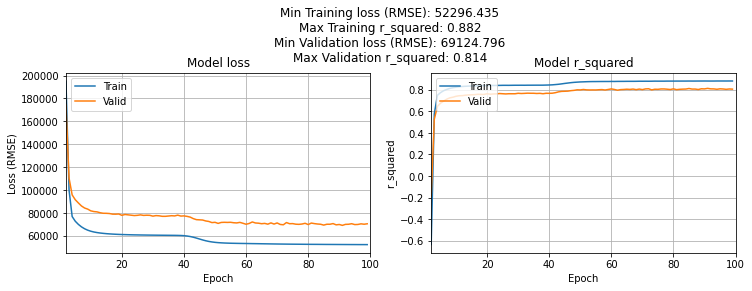

In [28]:
plot(q3.history)

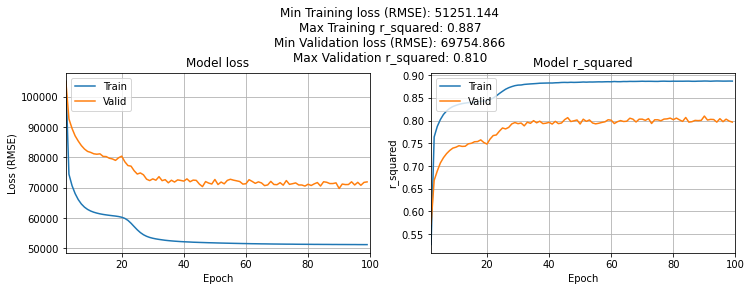

In [29]:
plot(q2.history)

validation data does not have data for September onwards

In [30]:
[sum(val_dataframe['month'] == i) for i in range(9, 13)]

[0, 0, 0, 0]

`dist_to_dhoby`
- the most important; its exclusion results in very large increase in val_loss (in order of 4 magnitudes)
    - likely due to houses closer to dhoby are not only central but also closer to town area (eg orchard), both of which are generally very desirable
    
Collecting the features whose removal leads to increase in val_loss (drop in performance) in both iterations, we have:
- `dist_to_nearest_stn`
- `remaining_lease_years`
- `storey_range`

This suggests that these 3 features, in addition to `dist_to_dhoby` are important factors in prediciting increse in `resale_price`

In [31]:
val_loss_memory.apply(lambda x: x - min(np.sqrt(q2.history['val_loss'])))

,w/o_month,w/o_dist_to_nearest_stn,w/o_dist_to_dhoby,w/o_degree_centrality,w/o_eigenvector_centrality,w/o_flat_model_type,w/o_remaining_lease_years,w/o_floor_area_sqm,w/o_storey_range
0,-6802.865866,1858.134134,2.330113e+04,-2276.865866,-4432.865866,4775.134134,597.134134,4760.134134,190.134134
1,inf,3089.134134,1.434713e+04,-4549.865866,-7549.865866,-94.865866,3105.134134,-6011.865866,353.134134
2,inf,-21.865866,2.065513e+04,-5714.865866,inf,3996.134134,2301.134134,-4678.865866,-2387.865866
3,inf,inf,inf,inf,inf,inf,inf,inf,inf
4,inf,inf,inf,inf,inf,inf,inf,inf,inf
5,inf,inf,inf,inf,inf,inf,inf,inf,inf
6,inf,inf,inf,inf,inf,inf,inf,inf,inf
7,inf,inf,inf,inf,inf,inf,inf,inf,inf
8,inf,inf,inf,inf,inf,inf,inf,inf,inf


To further improve performance, perhaps:
- more neurons could be used in the `Dense` layer
- vary the number of hidden `Dense` layers
- add dropout or other kinds of regularization